In [3]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
#X2=np.load('/home/miquel/ForMiquel/CLEAN2/X_c2_1j.npy')
#X3=np.load('/home/miquel/ForMiquel/CLEAN2/X_c3_1j.npy')
#X=np.concatenate((X1, X2), axis=1)
#X=np.concatenate((X, X3), axis=1)
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')

In [29]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365 
#dt=np.reshape(dt, (124,1))

In [13]:
def KFold(X_train, y_train, folds, linspace, dt, percentage):
    
    l=len(linspace)
    l2=X_train.shape[0]
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
    
    
    dt=np.reshape(dt, (l2,1))
    
    kf = cross_validation.KFold(l2, n_folds=folds)
    #spl2 = StratifiedShuffleSplit(n_splits=folds, test_size=0.3, random_state=42)
    fold = 1

    #for train_index_f, test_index_f in spl2.split(X_train, y_train):
    #    X_train_f = X_train[train_index_f,:]
    #    X_test_f = X_train[test_index_f,:]
    #    y_train_f = y_train[train_index_f]
    #    y_test_f = y_train[test_index_f]
    #   dt_test_f = dt[test_index_f]
    #    print("fold:", fold)
    #    fold = fold + 1
       
    
    for train_index_f, test_index_f in kf:  
        X_train_f = X_train[train_index_f,:]
        X_test_f = X_train[test_index_f,:]
        y_train_f = y_train[train_index_f]
        y_test_f = y_train[test_index_f]
        print("fold:", fold)
        fold = fold + 1
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            y_test_f = y[test_index_f]
            dt_test_f = dt[test_index_f]

    
            clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=c)
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            mask0 = np.where(dt_test_f>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    plt.figure(1)
    plt.plot(linspace, F, color='blue', label='F-measure')
    plt.legend(loc='best')
    plt.xlabel('C')
    plt.title('metrics logistic regression combination c1 and c2')
    plt.show()
    
    return maxi, maxi_idx
    

In [14]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage):
    
    F=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        print("split:", split)
        split = split + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
     
        maxi, maxi_idx = KFold(X_train_s, y_train, folds, linspace, dt_train, percentage)
        c = linspace[maxi_idx]

        clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight=0: 0.40, 1:0.60, C=10e-6)
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        
        if mask == 1:
            mask0 = np.where(dt_test>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test = y_test[mask0][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        f1=f1_score(y_test, pred)
        F.append(f1)
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)
    
    F_g=(2*TP)/(2*TP + FP + FN)

    
    print("F-values:", F)
    print("F_mean:", np.mean(F))
    print("F_g:", F_g)
    
    

        
        
        

split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


fold: 1
fold: 2


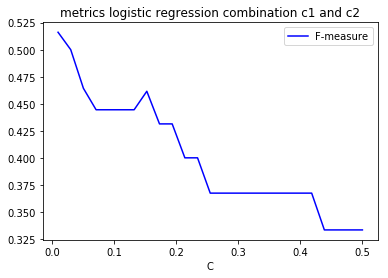

split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 1
fold: 2


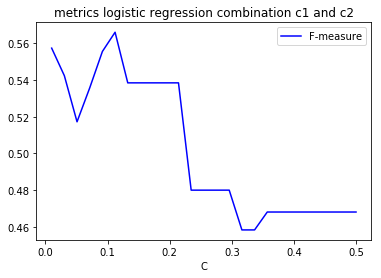

split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572692 572702 572703] are constant.
  UserWarning)


fold: 1
fold: 2


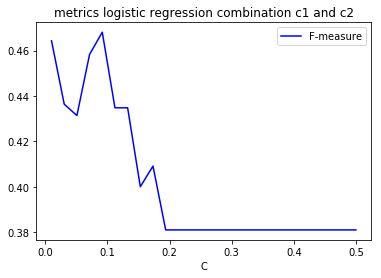

split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


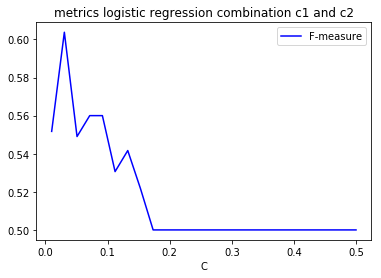

split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


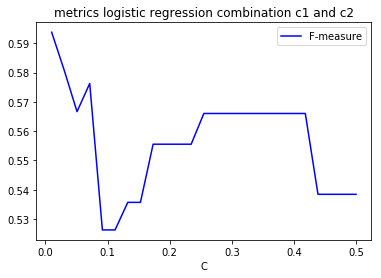

split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 1
fold: 2


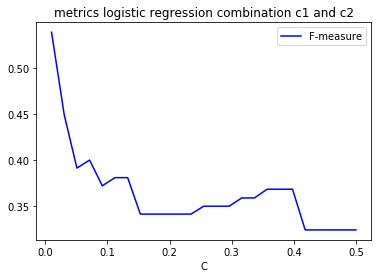

split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


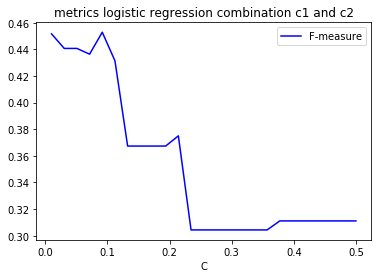

split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 1
fold: 2


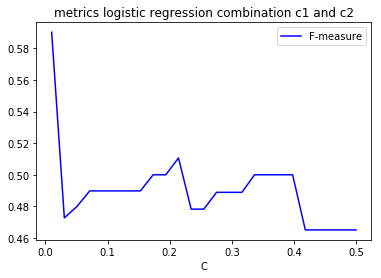

split: 9
fold: 1
fold: 2


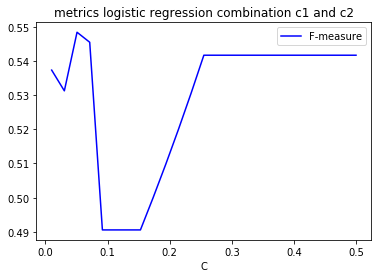

split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572473 572685 572704] are constant.
  UserWarning)


fold: 1
fold: 2


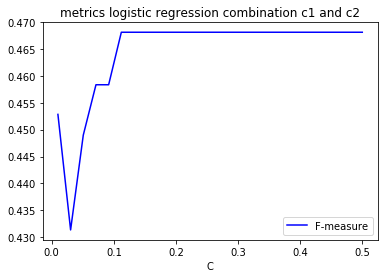

split: 11
fold: 1
fold: 2


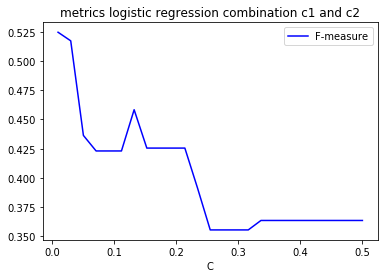

split: 12
fold: 1
fold: 2


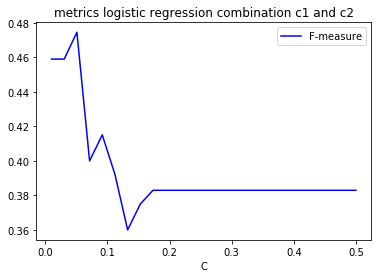

split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 1
fold: 2


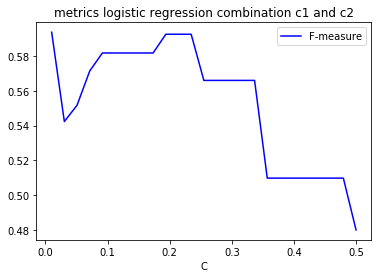

split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 1
fold: 2


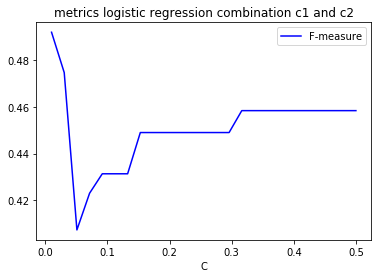

split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


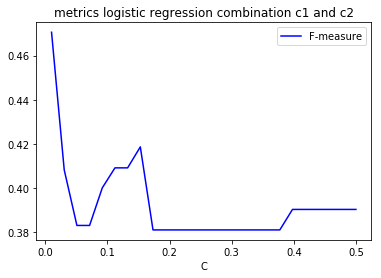

split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 1
fold: 2


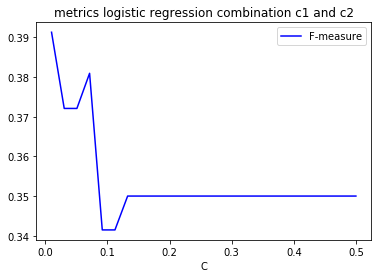

split: 17
fold: 1
fold: 2


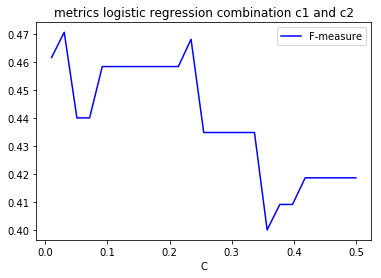

split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


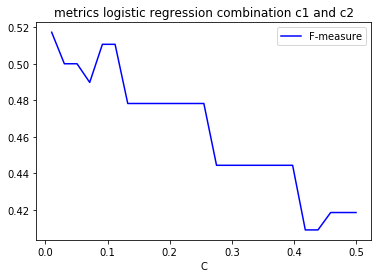

split: 19
fold: 1
fold: 2


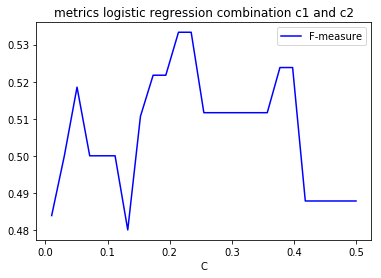

split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


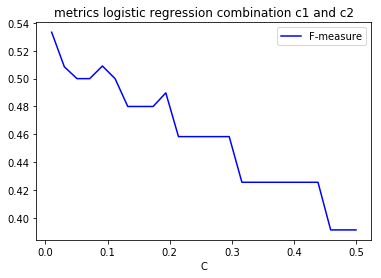

split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 1
fold: 2


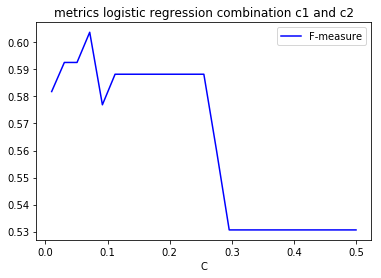

split: 22
fold: 1
fold: 2


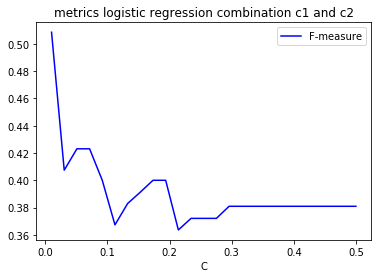

split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 1
fold: 2


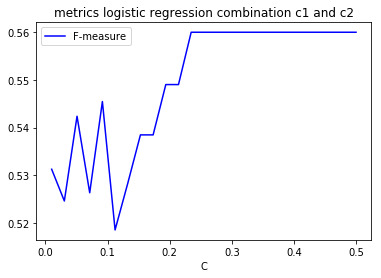

split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572510 572528 572553] are constant.
  UserWarning)


fold: 1
fold: 2


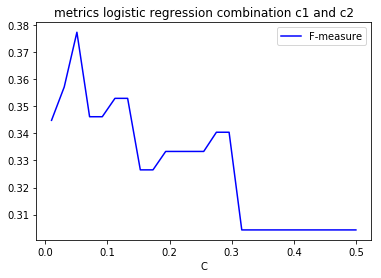

split: 25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


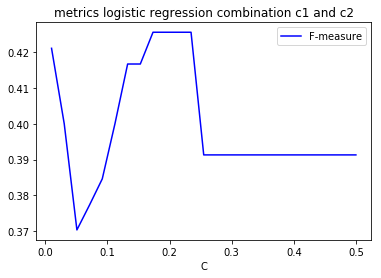

split: 26
fold: 1
fold: 2


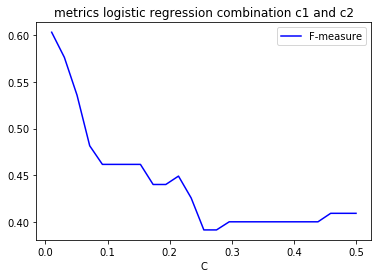

split: 27
fold: 1
fold: 2


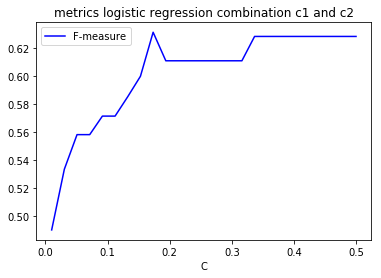

split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


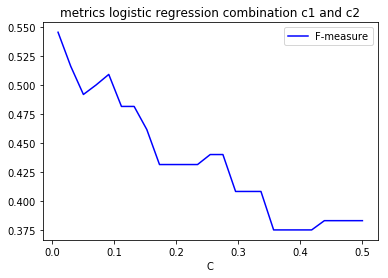

split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572231 572246 572461] are constant.
  UserWarning)


fold: 1
fold: 2


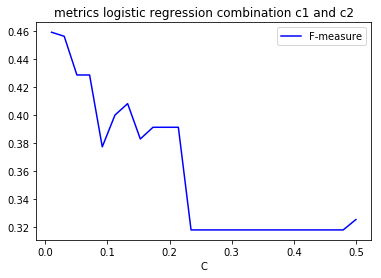

split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572707 572708 572709] are constant.
  UserWarning)


fold: 1
fold: 2


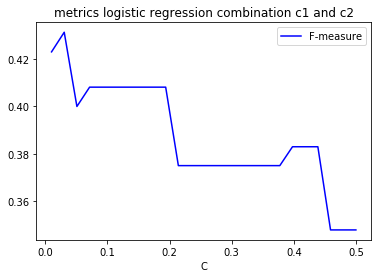

split: 31


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


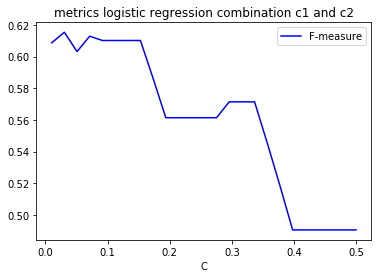

split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


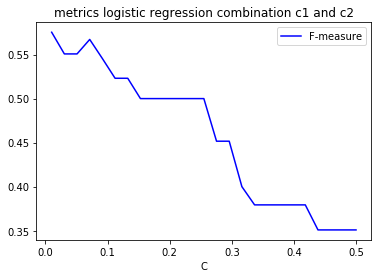

split: 33
fold: 1
fold: 2


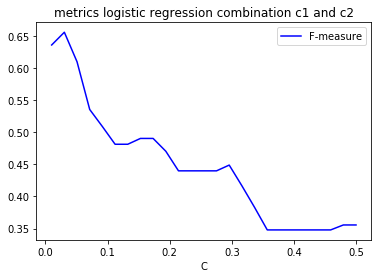

split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


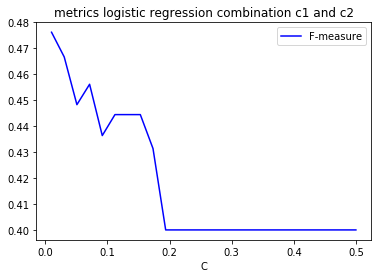

split: 35
fold: 1
fold: 2


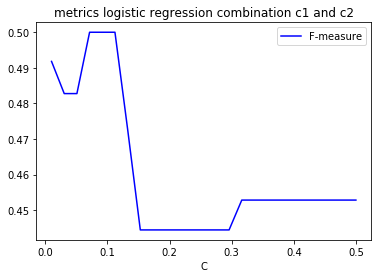

split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


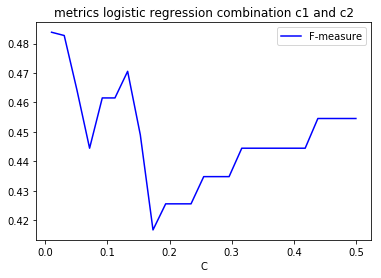

split: 37
fold: 1
fold: 2


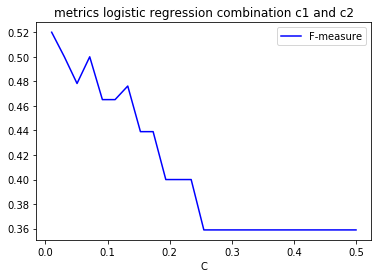

split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572510 572528 572685] are constant.
  UserWarning)


fold: 1
fold: 2


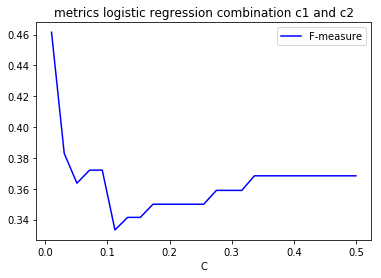

split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


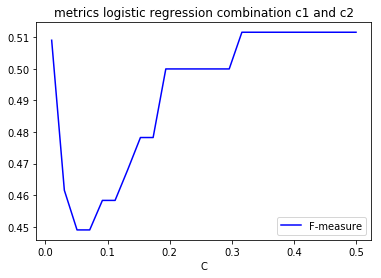

split: 40


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572594 572595 572596] are constant.
  UserWarning)


fold: 1
fold: 2


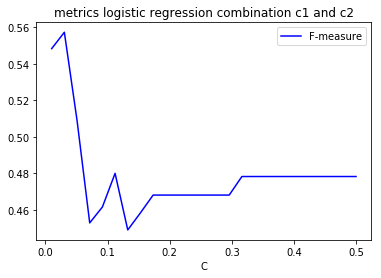

split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572712 572713 572714] are constant.
  UserWarning)


fold: 1
fold: 2


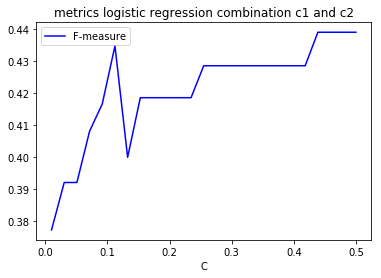

split: 42
fold: 1
fold: 2


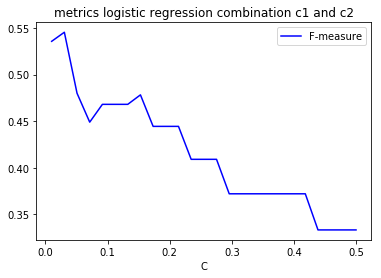

split: 43


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 1
fold: 2


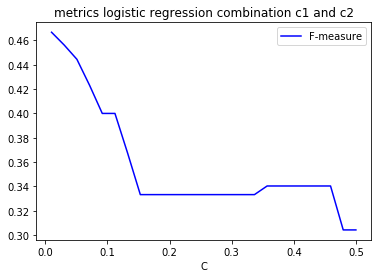

split: 44
fold: 1
fold: 2


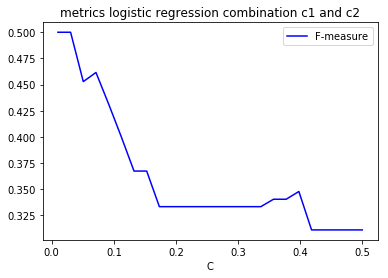

split: 45


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572703 572708 572709] are constant.
  UserWarning)


fold: 1
fold: 2


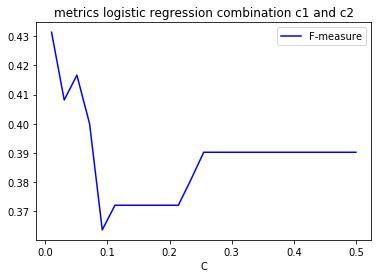

split: 46
fold: 1
fold: 2


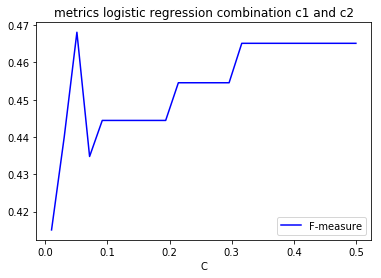

split: 47
fold: 1
fold: 2


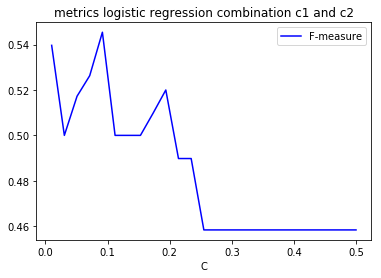

split: 48
fold: 1
fold: 2


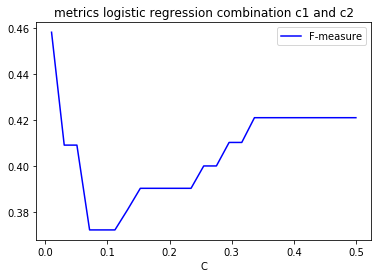

split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572685 572704] are constant.
  UserWarning)


fold: 1
fold: 2


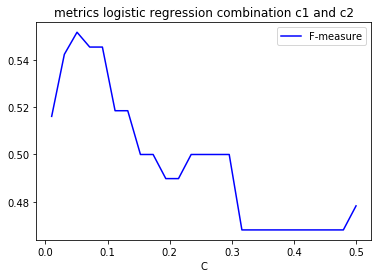

split: 50
fold: 1
fold: 2


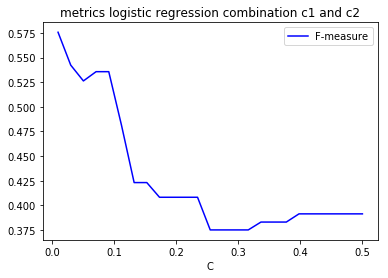

split: 51
fold: 1
fold: 2


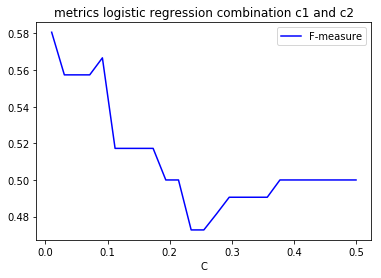

split: 52
fold: 1
fold: 2


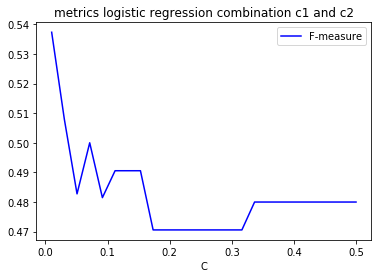

split: 53
fold: 1
fold: 2


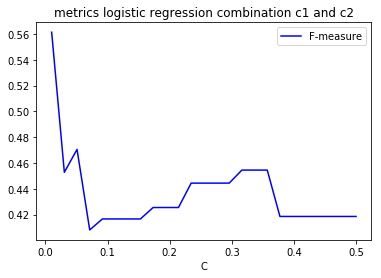

split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


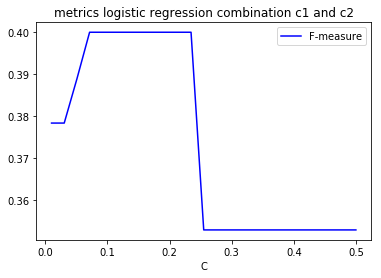

split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572735 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


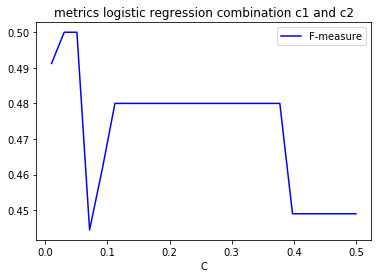

split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


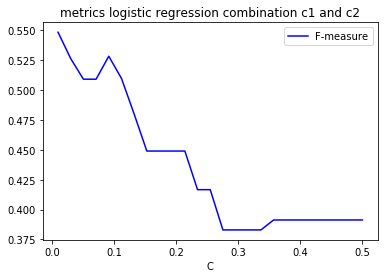

split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572704 572708 572709] are constant.
  UserWarning)


fold: 1
fold: 2


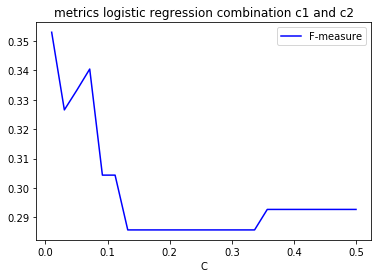

split: 58


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


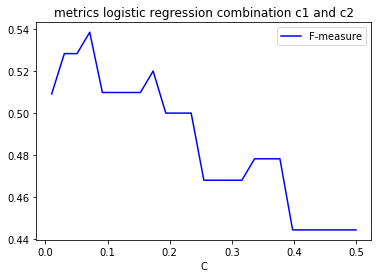

split: 59
fold: 1
fold: 2


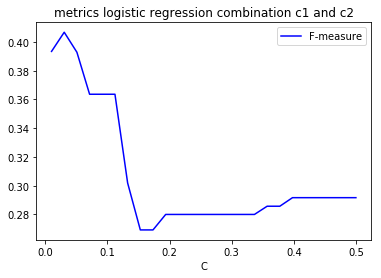

split: 60
fold: 1
fold: 2


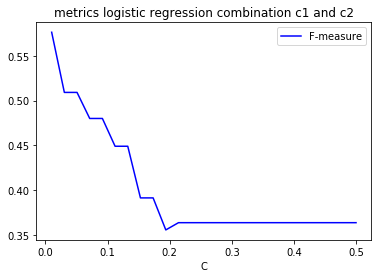

split: 61
fold: 1
fold: 2


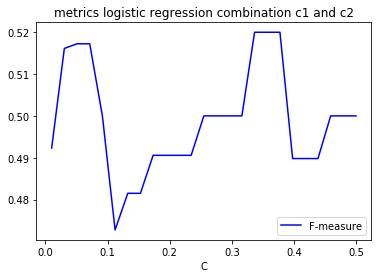

split: 62


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572720 572721 572722] are constant.
  UserWarning)


fold: 1
fold: 2


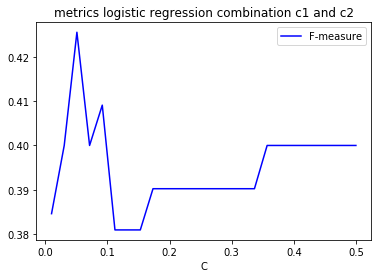

split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572731 572732 572735] are constant.
  UserWarning)


fold: 1
fold: 2


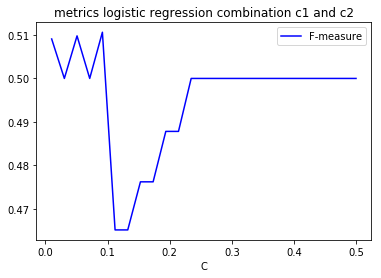

split: 64


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572702 572703 572704] are constant.
  UserWarning)


fold: 1
fold: 2


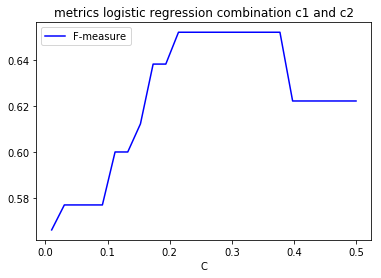

split: 65
fold: 1
fold: 2


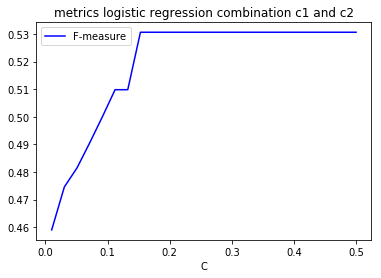

split: 66


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572728 572729 572730] are constant.
  UserWarning)


fold: 1
fold: 2


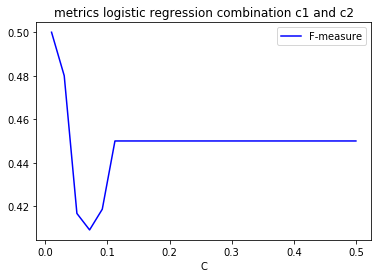

split: 67
fold: 1
fold: 2


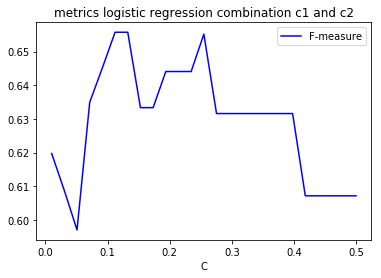

split: 68


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572685 572708 572709] are constant.
  UserWarning)


fold: 1
fold: 2


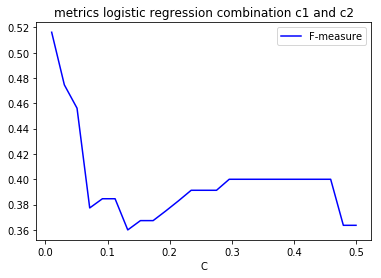

split: 69
fold: 1
fold: 2


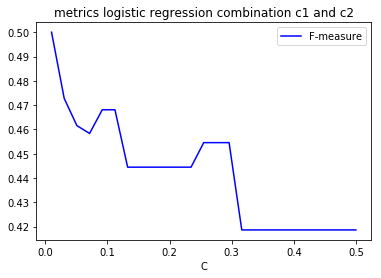

split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572733 572736 572737] are constant.
  UserWarning)


fold: 1
fold: 2


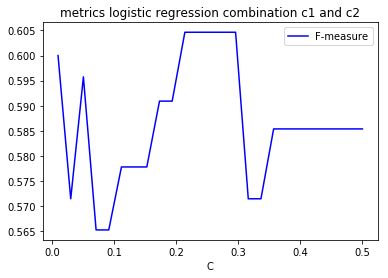

F-values: [0.52173913043478271, 0.66666666666666663, 0.69230769230769229, 0.59999999999999998, 0.58064516129032251, 0.52941176470588236, 0.60869565217391297, 0.66666666666666663, 0.58333333333333337, 0.75, 0.42857142857142855, 0.61538461538461531, 0.47999999999999998, 0.5625, 0.55172413793103448, 0.76190476190476197, 0.76190476190476197, 0.53846153846153855, 0.73684210526315785, 0.5161290322580645, 0.62500000000000011, 0.59259259259259256, 0.59259259259259256, 0.57142857142857151, 0.62500000000000011, 0.61538461538461531, 0.58333333333333337, 0.59259259259259256, 0.56000000000000005, 0.76190476190476197, 0.5, 0.38095238095238088, 0.62068965517241381, 0.66666666666666674, 0.44444444444444448, 0.58064516129032262, 0.625, 0.63636363636363635, 0.69565217391304346, 0.69565217391304357, 0.74074074074074081, 0.66666666666666674, 0.58064516129032251, 0.47999999999999998, 0.51851851851851849, 0.47619047619047622, 0.63157894736842102, 0.61111111111111105, 0.63636363636363635, 0.5, 0.560000000000

In [15]:
splits = 70
folds= 2
linspace = np.linspace(10e-3, 0.5, num=25)
percentage = 1.75
nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage)

In [34]:
def KFold_intern(X_train, y_train, folds, linspace, dt, percentage):
    
    l=len(linspace)
    l2=X_train.shape[0]
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
    
    
    dt=np.reshape(dt, (l2,1))
    
    kf = cross_validation.KFold(l2, n_folds=folds)
    #spl2 = StratifiedShuffleSplit(n_splits=folds, test_size=0.3, random_state=42)
    fold = 1

    #for train_index_f, test_index_f in spl2.split(X_train, y_train):
    #    X_train_f = X_train[train_index_f,:]
    #    X_test_f = X_train[test_index_f,:]
    #    y_train_f = y_train[train_index_f]
    #    y_test_f = y_train[test_index_f]
    #   dt_test_f = dt[test_index_f]
    #    print("fold:", fold)
    #    fold = fold + 1
       
    
    for train_index_f, test_index_f in kf:  
        X_train_f = X_train[train_index_f,:]
        X_test_f = X_train[test_index_f,:]
        y_train_f = y_train[train_index_f]
        y_test_f = y_train[test_index_f]
        print("fold:", fold)
        fold = fold + 1
        
        print("X_train_f shape:", np.shape(X_train_f))
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            y_test_f = y[test_index_f]
            dt_test_f = dt[test_index_f]
            
            S = SelectPercentile(percentile=percentage)
            S.fit(X_train_f, y_train_f)
        
            X_train_s = X_train_f[:,S.get_support()]
            X_test_s = X_test_f[:,S.get_support()]

    
            clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=c)
            clf.fit(X_train_s, y_train_f)
            pred = clf.predict(X_test_s)
            conf = confusion_matrix(y_test_f, pred)
            
            mask0 = np.where(dt_test_f>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    plt.figure(1)
    plt.plot(linspace, F, color='blue', label='F-measure')
    plt.legend(loc='best')
    plt.xlabel('C')
    plt.title('metrics logistic regression combination c1 and c2')
    plt.show()
    
    return maxi, maxi_idx

In [32]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage):
    
    F=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        print("split:", split)
        split = split + 1
     
        maxi, maxi_idx = KFold_intern(X_train, y_train, folds, linspace, dt_train, percentage)
        c = linspace[maxi_idx]
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]

        clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=c)
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        mask0 = np.where(dt_test>1.09)#~400 days
        mask0 = np.asarray(mask0)
        pred = pred[mask0][0]
        y_test = y_test[mask0][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        f1=f1_score(y_test, pred)
        F.append(f1)
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)
    
    F_g=(2*TP)/(2*TP + FP + FN)

    
    print("F-values:", F)
    print("F_mean:", np.mean(F))
    print("F_g:", F_g)
    
    

split: 1
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572735 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


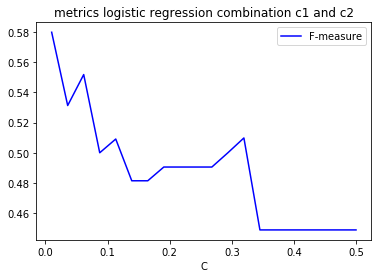

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 2
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572720 572721 572722] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4      5     13 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


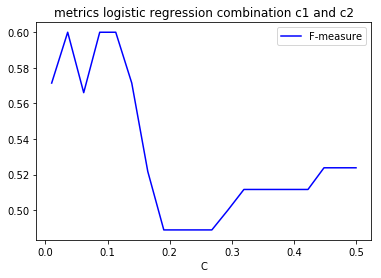

split: 3
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572707 572708 572709] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


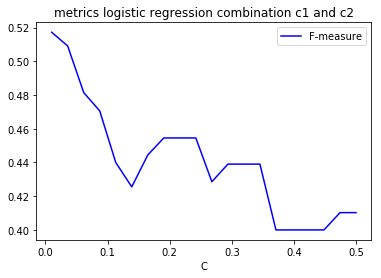

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 4
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


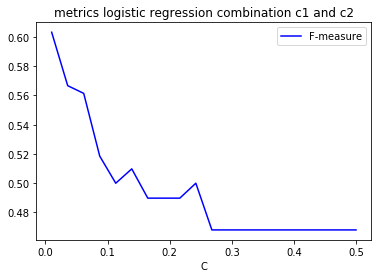

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    273 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 5
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     91 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

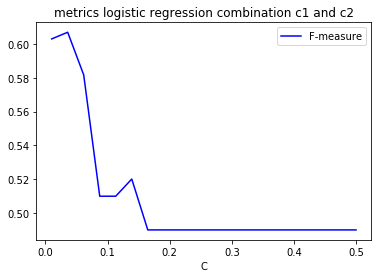

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572735 572736 572737] are constant.
  UserWarning)


split: 6
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


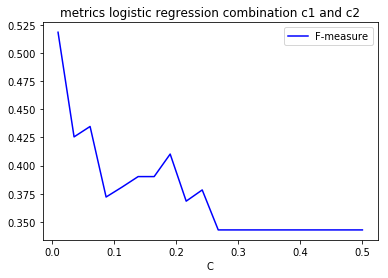

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 7
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


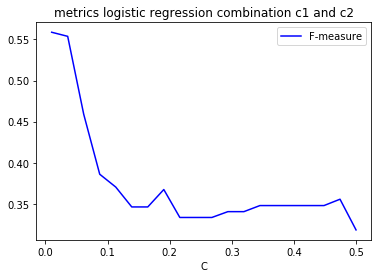

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 8
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     79 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


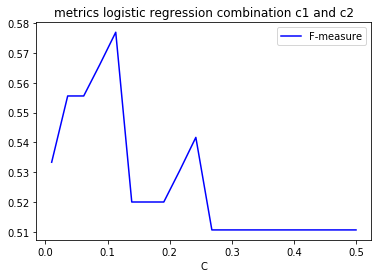

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 9
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

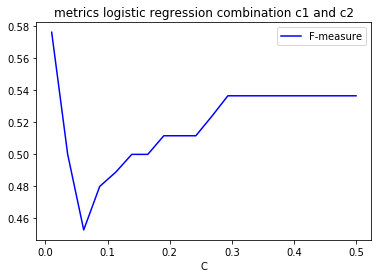

split: 10
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


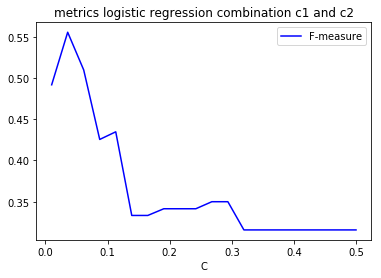

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572473 572685 572704] are constant.
  UserWarning)


split: 11
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

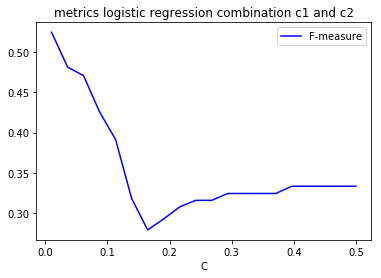

split: 12
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


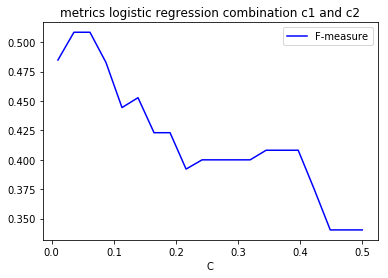

split: 13
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572720 572721 572722] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


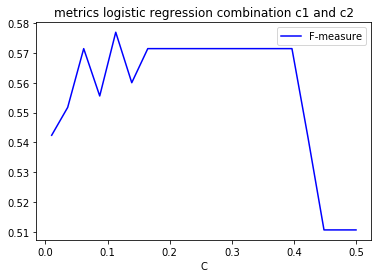

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572703 572708 572709] are constant.
  UserWarning)


split: 14
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


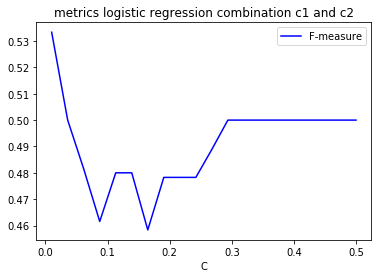

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 15
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

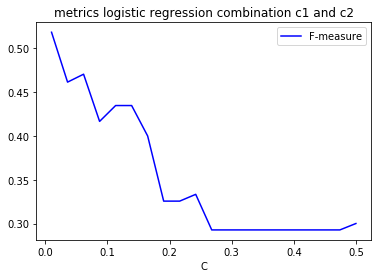

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 16
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     86 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572720 572721 572722] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


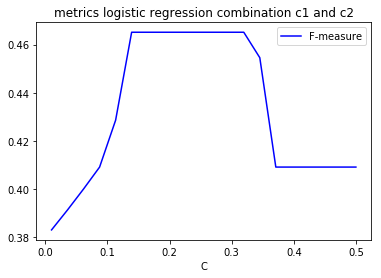

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 17
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

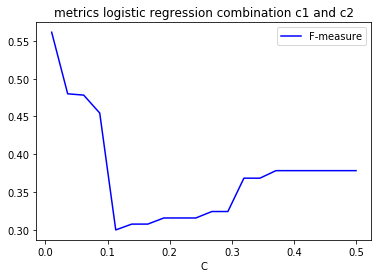

split: 18
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

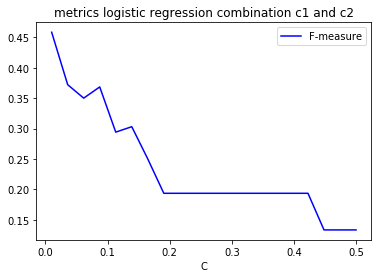

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 19
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     83 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

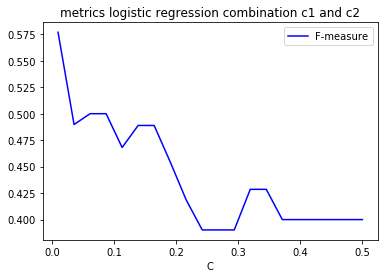

split: 20
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

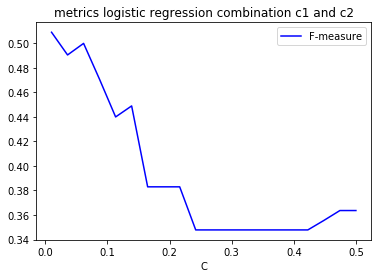

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 21
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     89     90 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

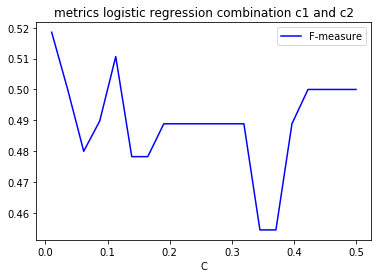

split: 22
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

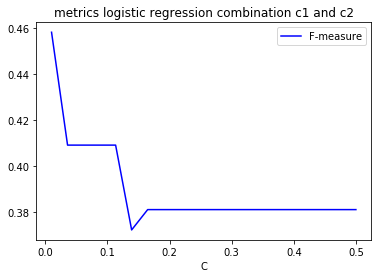

split: 23
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4      5     13 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

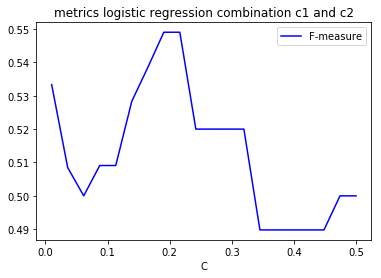

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 24
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     90 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

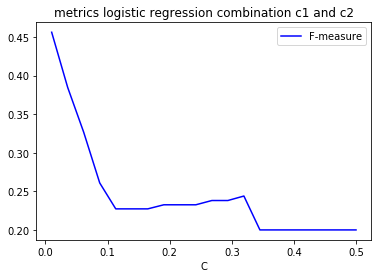

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572510 572528 572553] are constant.
  UserWarning)


split: 25
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

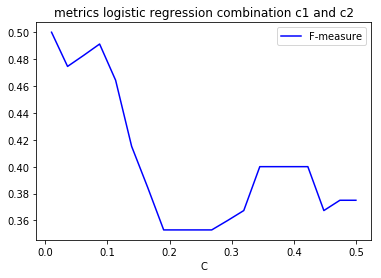

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 26
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

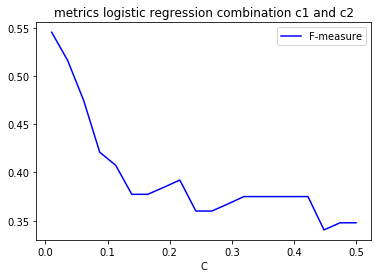

split: 27
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


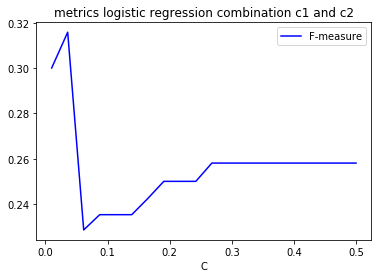

split: 28
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

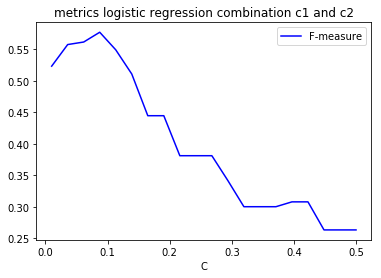

split: 29
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


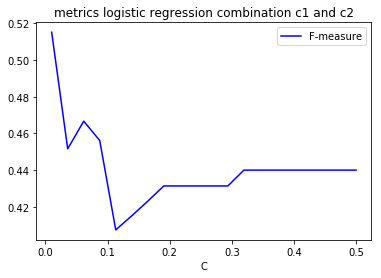

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572231 572246 572461] are constant.
  UserWarning)


split: 30
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572707 572708 572709] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


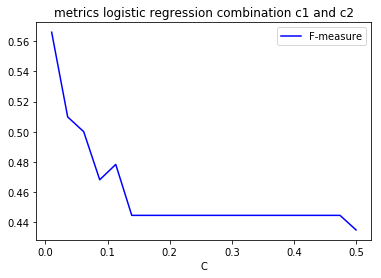

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572707 572708 572709] are constant.
  UserWarning)


split: 31
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      4     13 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


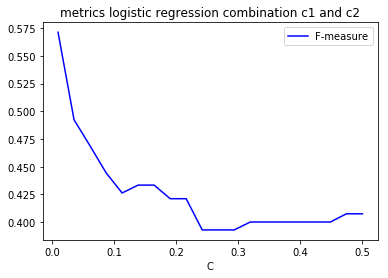

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 32
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0     13     71 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


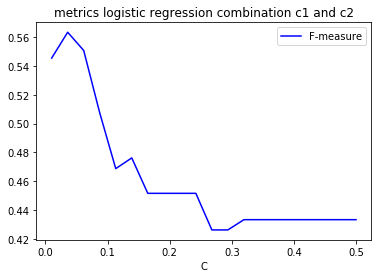

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 33
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     72 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


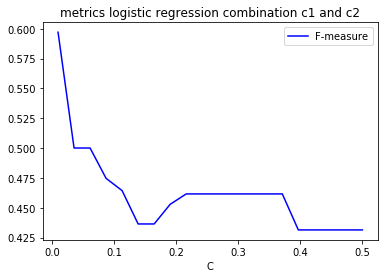

split: 34
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


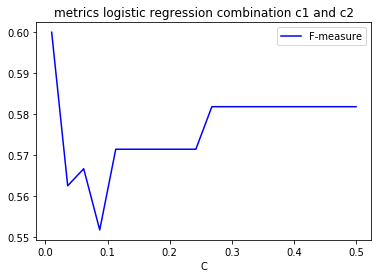

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 35
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

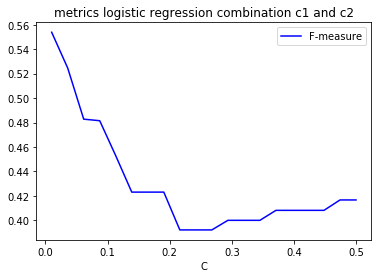

split: 36
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

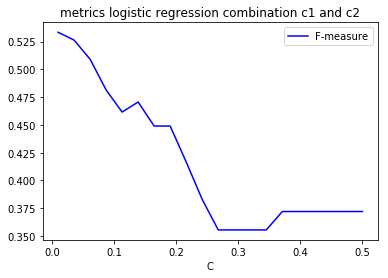

split: 37
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     91 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


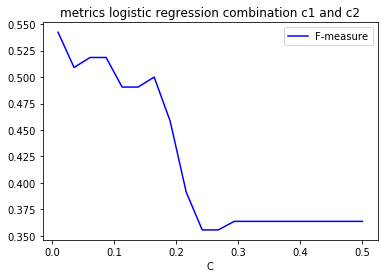

split: 38
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

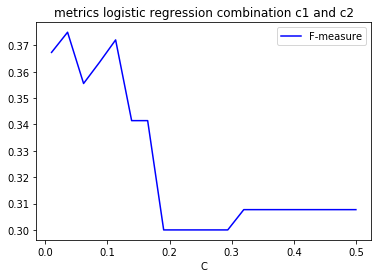

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572510 572528 572685] are constant.
  UserWarning)


split: 39
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

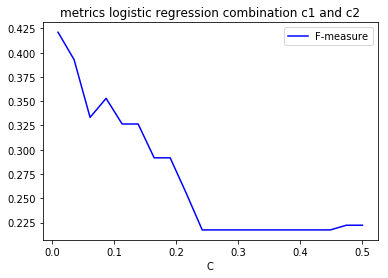

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    290 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 40
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4      5     13 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


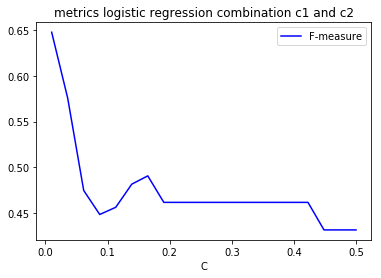

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572594 572595 572596] are constant.
  UserWarning)


split: 41
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

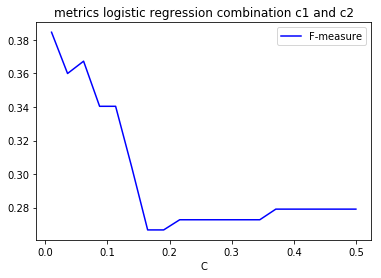

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 42
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     83 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

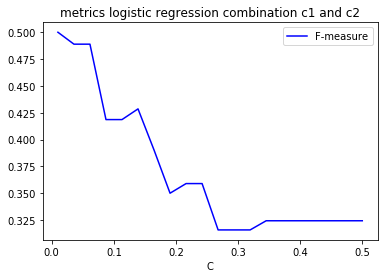

split: 43
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


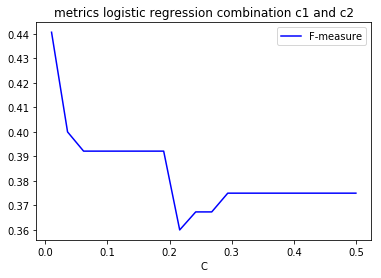

split: 44
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     71 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


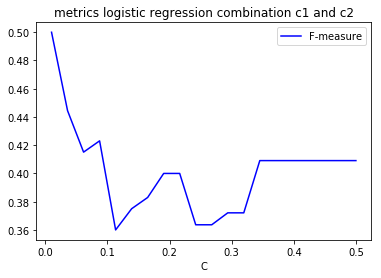

split: 45
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


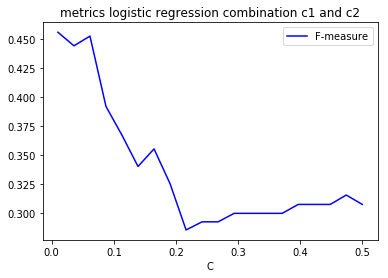

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572703 572708 572709] are constant.
  UserWarning)


split: 46
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

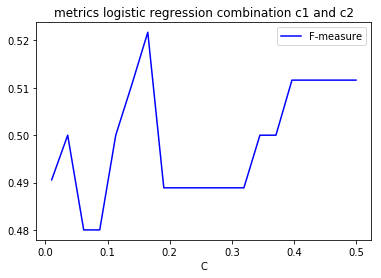

split: 47
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

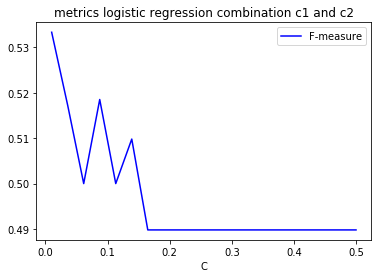

split: 48
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      4     13 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


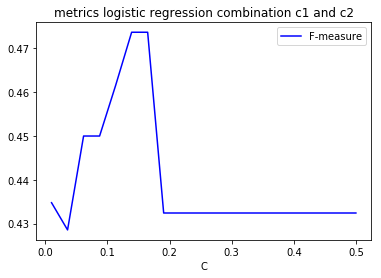

split: 49
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572705 572708 572709] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

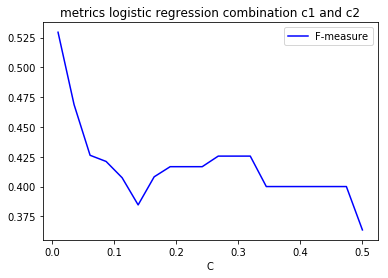

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572677 572685 572704] are constant.
  UserWarning)


split: 50
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

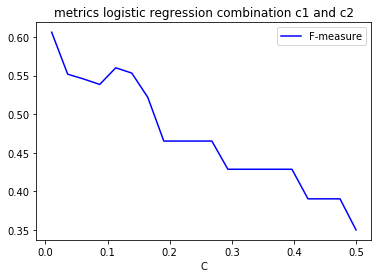

split: 51
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     89 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

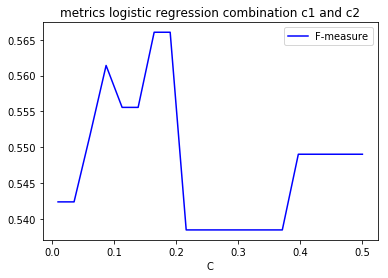

split: 52
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

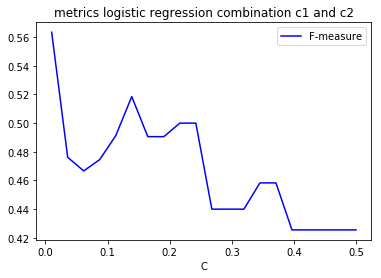

split: 53
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

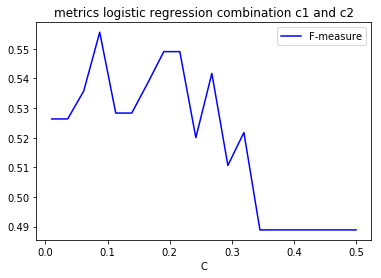

split: 54
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


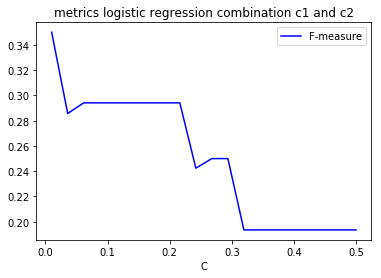

split: 55
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

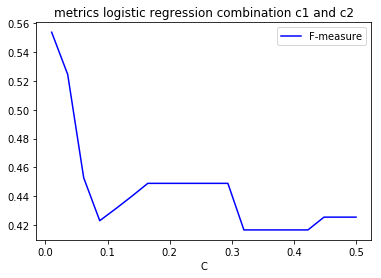

split: 56
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

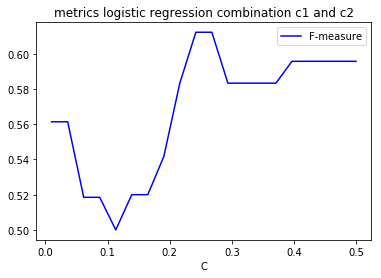

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     99 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 57
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

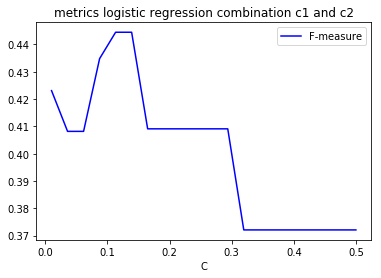

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572704 572708 572709] are constant.
  UserWarning)


split: 58
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

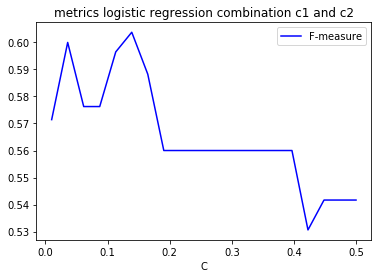

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 59
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

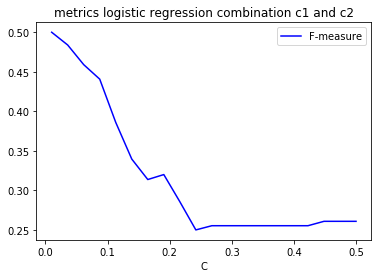

split: 60
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     71 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


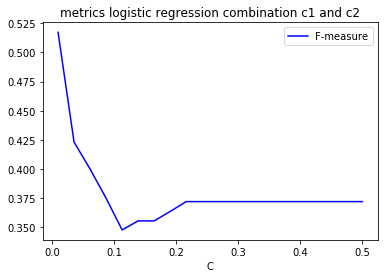

split: 61
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

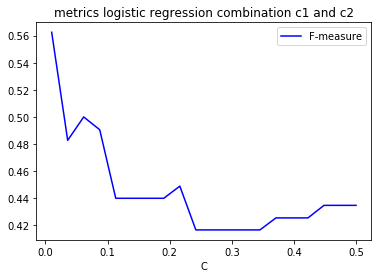

split: 62
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

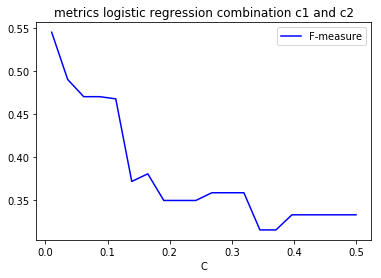

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 63
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

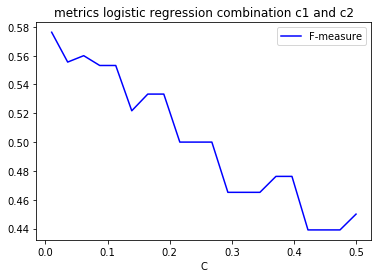

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 64
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     90 ..., 572733 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


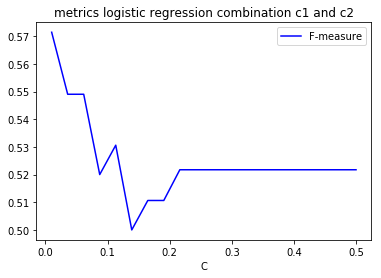

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572702 572703 572704] are constant.
  UserWarning)


split: 65
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

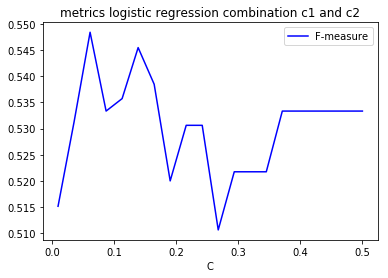

split: 66
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572728 572729 572730] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


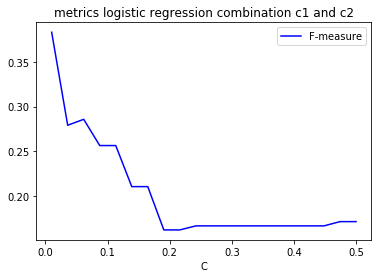

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 67
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572735 572736 572737] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_

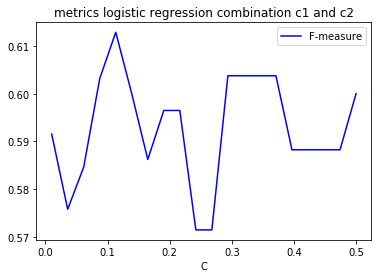

split: 68
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572731 572732 572735] are constant.
  UserWarning)


X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)


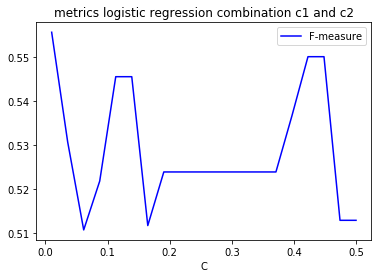

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 69
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

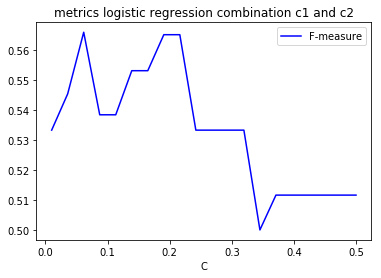

split: 70
X_TRAIN SHAPE: (86, 572738)
fold: 1
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
fold: 2
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape: (43, 572738)
X_train_f shape:

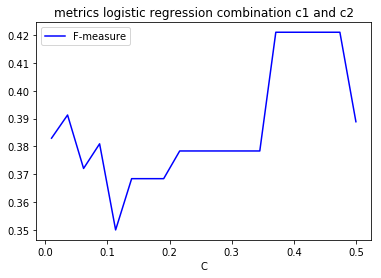

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572733 572736 572737] are constant.
  UserWarning)


F-values: [0.52173913043478271, 0.76923076923076927, 0.56250000000000011, 0.59999999999999998, 0.62068965517241381, 0.52941176470588236, 0.48275862068965514, 0.6923076923076924, 0.5, 0.66666666666666674, 0.42857142857142855, 0.59259259259259256, 0.54545454545454541, 0.5625, 0.55172413793103448, 0.70000000000000007, 0.71999999999999997, 0.53846153846153855, 0.53846153846153844, 0.5161290322580645, 0.58823529411764697, 0.59259259259259256, 0.59259259259259256, 0.58333333333333337, 0.64000000000000001, 0.61538461538461531, 0.59259259259259256, 0.66666666666666663, 0.56000000000000005, 0.72727272727272718, 0.46153846153846156, 0.44444444444444442, 0.59999999999999998, 0.66666666666666674, 0.44444444444444448, 0.58064516129032262, 0.625, 0.59999999999999998, 0.58064516129032251, 0.66666666666666663, 0.58823529411764708, 0.64516129032258063, 0.58064516129032251, 0.47999999999999998, 0.51851851851851849, 0.5, 0.52173913043478271, 0.68749999999999989, 0.58333333333333337, 0.5, 0.63157894736842

In [35]:
splits = 70
folds= 2
linspace = np.linspace(10e-3, 0.5, num=20)
percentage = 1.75
nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage)